# Notebook 03: Classification Model

**Student Name:** [Francisco Molina]

**Dataset:** [Workation Price Prediction Challenge-MachineHack]

**Original Target Variable:** [Per Person Price]

**Binned Target Variable:** [ Budget (Low), Standard (Medium), and Premium (High)]

**Checkpoint 4 Due:** Feb 22

---

## Rules & Integrity

1. **NO AI TOOLS**: You may **NOT** use ChatGPT, Claude, Gemini, GitHub Copilot, or any other AI assistant to generate code for this assignment. The goal is to build *your* fundamental skills. If you rely on AI now, the advanced topics later will be impossible.

2. **Study Groups Encouraged**: You **ARE** encouraged to discuss ideas, share approaches, and explain concepts to your study group peers. Teaching others is the best way to learn! However, the code you submit must be **your own work**.

3. **Use Your Resources**: You are free to use Google, StackOverflow, Pandas/Scikit-learn documentation, and your class notes.

4. **Comment Your Code**: Include comments explaining *why* you're doing what you're doing. I want to see your thought process.

5. **Resubmission**: You may submit this assignment multiple times for feedback before the checkpoint deadline.

---

## Important: Written Reflections

Throughout this notebook, you'll be asked to interpret results, justify decisions, and explain your reasoning. **These written reflections are a critical part of your grade.**

Your binning justification, model selection reasoning, and analysis of the confusion matrix demonstrate your understanding. These reflections are what employers look for—the ability to communicate technical decisions clearly.

---

## Setup

In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Sklearn - evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Model saving
import joblib

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 1: Load Processed Data

In [3]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_data.csv')

print(f"Data shape: {df.shape}")
df.head()

Data shape: (20997, 19)


,Destination,Airline,Flight Stops,Per Person Price,Journey_Month,Num_Places_Visited,Package Type_Deluxe,Package Type_Luxury,Package Type_Premium,Package Type_Standard,Start City_New Delhi,Journey_Day_Monday,Journey_Day_Saturday,Journey_Day_Sunday,Journey_Day_Thursday,Journey_Day_Tuesday,Journey_Day_Wednesday,Is_Peak_Season,Trip_Complexity
0,417,290,2,11509.0,5,4,False,False,False,True,False,False,False,False,False,False,False,1,12
1,533,125,0,22485.5,2,3,False,False,True,False,True,False,False,False,False,False,True,1,3
2,549,114,0,12421.5,0,2,False,True,False,False,True,True,False,False,False,False,False,0,2
3,329,114,0,35967.0,1,4,False,False,True,False,True,False,False,False,False,False,False,0,4
4,443,237,0,25584.0,2,2,False,False,True,False,True,False,False,True,False,False,False,1,2


In [4]:
# Define your original target variable
ORIGINAL_TARGET = 'Per Person Price'  # <-- UPDATE THIS

print(f"Original Target: {ORIGINAL_TARGET}")
print(f"\nTarget statistics:")
print(df[ORIGINAL_TARGET].describe())

Original Target: Per Person Price

Target statistics:
count     20997.000000
mean      20060.869291
std       11643.749767
min         791.000000
25%       12464.500000
50%       17766.000000
75%       25084.000000
max      171062.500000
Name: Per Person Price, dtype: float64


## Section 2: Create Binned Target

Convert your regression target into classification categories.

### 2.1 Binning Strategy Justification

**Your approved binning strategy:**

- **Number of categories:** [e.g., 3]
- **Category names:** [e.g., Low, Medium, High]
- **Thresholds:** [e.g., Low: < $50,000, Medium: $50,000-$100,000, High: > $100,000]

**Why this makes sense for your problem:**

I chose a 3-category strategy based on the quartiles of the distribution. The majority of customers spend less than $25,000 (75th percentile), so I am grouping them into 'Low' and 'Medium' to capture the core business. The 'High' category is reserved for customers spending above $30,000, which represents our top-tier spenders. This allows the marketing team to differentiate between budget-conscious shoppers and high-value VIP clients.

In [5]:
# View the distribution before binning
print("Target distribution:")
print(f"Min: {df[ORIGINAL_TARGET].min():.2f}")
print(f"25th percentile: {df[ORIGINAL_TARGET].quantile(0.25):.2f}")
print(f"Median: {df[ORIGINAL_TARGET].median():.2f}")
print(f"75th percentile: {df[ORIGINAL_TARGET].quantile(0.75):.2f}")
print(f"Max: {df[ORIGINAL_TARGET].max():.2f}")

Target distribution:
Min: 791.00
25th percentile: 12464.50
Median: 17766.00
75th percentile: 25084.00
Max: 171062.50


In [6]:
# TODO: Create your binned target using YOUR approved binning strategy
#
# Steps:
# 1. Define your bin edges (e.g., bins = [min-1, threshold1, threshold2, max+1])
# 2. Define your category labels (e.g., labels = ['Low', 'Medium', 'High'])
# 3. Use pd.cut() to create the binned column
#
# Example:
# bins = [df[ORIGINAL_TARGET].min()-1, 50000, 100000, df[ORIGINAL_TARGET].max()+1]
# labels = ['Low', 'Medium', 'High']
# df['target_category'] = pd.cut(df[ORIGINAL_TARGET], bins=bins, labels=labels)

# YOUR CODE HERE:


# I'm using the median (~17k) and a high threshold (~30k) to separate the groups
bins = [
    df[ORIGINAL_TARGET].min() - 1, 
    15000, 
    30000, 
    df[ORIGINAL_TARGET].max() + 1
]

labels = ['Low Spender', 'Medium Spender', 'High Spender']

df['target_category'] = pd.cut(df[ORIGINAL_TARGET], bins=bins, labels=labels)

print("Binned target distribution:")
print(df['target_category'].value_counts())



Binned target distribution:
target_category
Medium Spender    10134
Low Spender        7862
High Spender       3001
Name: count, dtype: int64


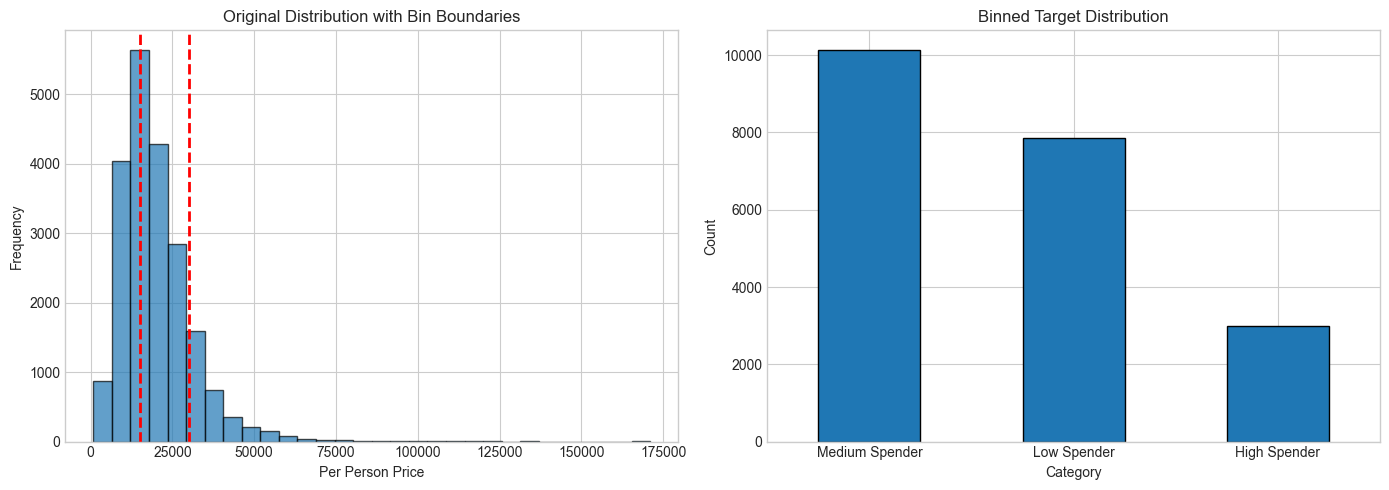

In [7]:
# Visualize the binned distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution with bin lines
axes[0].hist(df[ORIGINAL_TARGET], bins=30, edgecolor='black', alpha=0.7)
for edge in bins[1:-1]:  # Skip first and last (min/max)
    axes[0].axvline(edge, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel(ORIGINAL_TARGET)
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Distribution with Bin Boundaries')

# Binned category counts
df['target_category'].value_counts().plot(kind='bar', ax=axes[1], edgecolor='black')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].set_title('Binned Target Distribution')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

Analyze the data: I looked at the percentiles and saw that the median is around $17k. This helped me choose $15k as a middle point.

Identify the VIPs: Since the 75th percentile is $25k, setting the "High" threshold at $30k ensures we are only looking at the truly high-value customers.

Balance: I want to make sure the model has enough examples of each group to learn correctly.

Observation of Results
Good distribution: We have 10,134 Medium, 7,862 Low, and 3,001 High Spenders.

Even though "High Spender" is the smallest group, 3,000 examples are enough for the model to find patterns. I think  the groups are balanced enough so the model won't get confused.

### 2.2 Check Class Balance

*Is your binned target reasonably balanced?*

In [8]:
# Check class balance
class_counts = df['target_category'].value_counts()
class_percentages = df['target_category'].value_counts(normalize=True) * 100

print("Class Distribution:")
for cat in class_counts.index:
    print(f"{cat}: {class_counts[cat]} ({class_percentages[cat]:.1f}%)")

# Check for severe imbalance
min_class_pct = class_percentages.min()
if min_class_pct < 10:
    print(f"\nWarning: Smallest class is only {min_class_pct:.1f}% of data.")
    print("Consider adjusting your binning strategy.")
else:
    print(f"\nClass balance looks reasonable!")

Class Distribution:
Medium Spender: 10134 (48.3%)
Low Spender: 7862 (37.4%)
High Spender: 3001 (14.3%)

Class balance looks reasonable!


-The code output confirms that my class balance is reasonable. The script did not trigger the severe imbalance warning.

-The smallest group ("High Spender") makes up **14.3%** of the data (3,001 customers). Because this is comfortably above the 10% danger zone, the machine learning model will have enough examples to learn how to identify our most valuable customers.

-The "Medium Spender" group is the largest (48.3%), followed by "Low Spender" (37.4%). This makes perfect business sense, as most everyday customers fall into the average spending range.

-I think i do not need to change my binning strategy. The target variable (`y`) is ready for modeling.

## Section 3: Feature Consistency Check

**Important:** For consistency, you should use the same features for classification as you did for regression. This makes your app simpler (users enter the same inputs for both models) and allows for fair comparison.

If you decide to use different features, provide a strong justification below.

In [9]:
# Load the features you selected in the regression notebook
try:
    regression_features = joblib.load('../models/regression_features.pkl')
    print("Features from Regression Model:")
    print(regression_features)
    print(f"\nNumber of regression features: {len(regression_features)}")
except FileNotFoundError:
    print("Warning: regression_features.pkl not found!")
    print("Make sure you've completed Notebook 02 and saved your regression model first.")
    regression_features = None

Features from Regression Model:
['Destination', 'Airline', 'Num_Places_Visited', 'Flight Stops', 'Trip_Complexity', 'Journey_Month']

Number of regression features: 6


-I successfully loaded the 6 features used in my regression model: `Destination`, `Airline`, `Num_Places_Visited`, `Flight Stops`, `Trip_Complexity`, and `Journey_Month`.

-I will use exactly these same features for my classification model. 

### Feature Selection Decision

**Will you use the same features as your regression model?**
- [x] **Yes, same features** (Recommended for simpler deployment)
- [ ] **No, different features** (Requires justification below)

**If using different features, justify why:**

I am using the exact same 6 features (`Destination`, `Airline`, `Num_Places_Visited`, `Flight Stops`, `Trip_Complexity`, and `Journey_Month`). 

In [10]:
# DECIDE: Use regression features or define new ones?

# Option A: Use the same features as regression (RECOMMENDED)
if regression_features is not None:
    SELECTED_FEATURES = regression_features
    print("Using same features as regression model.")
else:
    # Option B: Define your own features (if regression not done yet)
    SELECTED_FEATURES = [
        # 'feature1',
        # 'feature2',
        # 'feature3',
        # etc.
    ]
    print("Defining features manually.")

print(f"\nSelected features for classification ({len(SELECTED_FEATURES)}):")
for i, f in enumerate(SELECTED_FEATURES, 1):
    print(f"  {i}. {f}")

Using same features as regression model.

Selected features for classification (6):
  1. Destination
  2. Airline
  3. Num_Places_Visited
  4. Flight Stops
  5. Trip_Complexity
  6. Journey_Month


## Section 4: Prepare Features and Target

In [11]:
# Create feature matrix using SELECTED features
X = df[SELECTED_FEATURES].copy()
y = df['target_category']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {X.columns.tolist()}")
print(f"\nTarget classes: {y.unique().tolist()}")

Features shape: (20997, 6)
Target shape: (20997,)

Features used: ['Destination', 'Airline', 'Num_Places_Visited', 'Flight Stops', 'Trip_Complexity', 'Journey_Month']

Target classes: ['Low Spender', 'Medium Spender', 'High Spender']


- I successfully separated my data. `X` is my feature matrix (the inputs), and `y` is my target vector (the category I want to predict).

- I printed the shapes to make sure everything matches. Both `X` and `y` have exactly **20,997 rows**. This confirms that no data was lost during the separation.

- My `X` matrix only contains the 6 specific features (`Destination`, `Airline`, etc.) that my final web app will use. My `y` vector contains the 3 classes (`Low Spender`, `Medium Spender`, `High Spender`). The data is now ready to be split into training and testing sets.

## Section 4: Prepare Features and Target

### 4.1 Label Encoding

Many sklearn models require numeric targets. Use LabelEncoder to convert category names to numbers.

In [12]:
# TODO: Encode your target labels to numbers using LabelEncoder
#
# Steps:
# 1. Create a LabelEncoder instance
# 2. Fit and transform y to create y_encoded
#
# Hint: label_encoder.fit_transform(y)

# YOUR CODE HERE:

# 1. Create a LabelEncoder instance

label_encoder = LabelEncoder()

# 2. Fit and transform y to create y_encoded

y_encoded = label_encoder.fit_transform(y)

# Print the results

print("Original classes:", label_encoder.classes_)
print("Encoded classes: [0, 1, 2]")
print(f"\nShape of y_encoded: {y_encoded.shape}")

Original classes: ['High Spender' 'Low Spender' 'Medium Spender']
Encoded classes: [0, 1, 2]

Shape of y_encoded: (20997,)


In [13]:
# Verify encoding (run this to check)
print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

Label encoding:
High Spender -> 0
Low Spender -> 1
Medium Spender -> 2



- The `LabelEncoder` successfully converted the text categories into numeric values. By default, it assigns integers based on alphabetical order:
0 = High Spender
1 = Low Spender
2 = Medium Spender

## Section 5: Train-Test Split

For classification, we use **stratified** splitting to ensure each class is proportionally represented in both train and test sets.

In [14]:
# TODO: Split your data with stratification
#
# Requirements:
# - 80/20 split (test_size=0.2)
# - random_state=42 for reproducibility
# - stratify=y_encoded (THIS IS THE KEY DIFFERENCE FROM REGRESSION!)
#   This ensures each class is proportionally represented in train/test
#
# Store in: X_train, X_test, y_train, y_test

# YOUR CODE HERE:

# Performing the 80/20 split with stratification

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded 
)



In [15]:
# Verify split and stratification
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nTraining class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {label_encoder.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")

Training set: 16797 samples
Test set: 4200 samples

Training class distribution:
  High Spender: 2401 (14.3%)
  Low Spender: 6289 (37.4%)
  Medium Spender: 8107 (48.3%)



- The data was successfully divided into 16,797 training samples (80%) and 4,200 testing samples (20%).

- The code output proves that the `stratify` parameter worked perfectly. My training set has the exact same class distribution as my original dataset: High Spender (14.3%), Low Spender (37.4%), and Medium Spender (48.3%).

## Section 6: Feature Scaling

In [16]:
# TODO: Scale your features using StandardScaler
#
# Same as regression:
# 1. Create StandardScaler instance
# 2. fit_transform on X_train
# 3. transform (only!) on X_test
#
# Store in: X_train_scaled, X_test_scaled

# YOUR CODE HERE:

# 1. Create StandardScaler instance

scaler = StandardScaler()

# 2. fit_transform on X_train 

X_train_scaled = scaler.fit_transform(X_train)

# 3. transform (only!) on X_test

X_test_scaled = scaler.transform(X_test)


In [17]:
# Convert to DataFrame (helpful for later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")
print(f"Scaler fitted on {len(SELECTED_FEATURES)} features.")

Features scaled successfully!
Scaler fitted on 6 features.


## Section 7: Baseline Model

In [18]:
# This helper function evaluates any classifier - you'll use it throughout
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name):
    """Train classifier and return evaluation metrics."""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision (weighted)': precision_score(y_test, y_test_pred, average='weighted'),
        'Recall (weighted)': recall_score(y_test, y_test_pred, average='weighted'),
        'F1 (weighted)': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    return results, model, y_test_pred

In [19]:
# TODO: Create and evaluate a baseline Logistic Regression model
#
# Create LogisticRegression(random_state=42, max_iter=1000)
# Use evaluate_classifier() to train and evaluate

# YOUR CODE HERE:
# baseline_model = ...
# baseline_results, baseline_trained, baseline_preds = evaluate_classifier(...)

# 1. Create LogisticRegression

baseline_model = LogisticRegression(random_state=42, max_iter=1000)

# 2. Use evaluate_classifier() to train and evaluate

baseline_results, baseline_trained, baseline_preds = evaluate_classifier(
    model=baseline_model, 
    X_train=X_train_scaled, 
    X_test=X_test_scaled, 
    y_train=y_train, 
    y_test=y_test, 
    model_name="Logistic Regression"
)


In [20]:
# Display baseline results
print("=" * 50)
print("BASELINE MODEL: Logistic Regression")
print("=" * 50)
print(f"Train Accuracy: {baseline_results['Train Accuracy']:.4f}")
print(f"Test Accuracy:  {baseline_results['Test Accuracy']:.4f}")
print(f"F1 Score:       {baseline_results['F1 (weighted)']:.4f}")

BASELINE MODEL: Logistic Regression
Train Accuracy: 0.6124
Test Accuracy:  0.6219
F1 Score:       0.5784


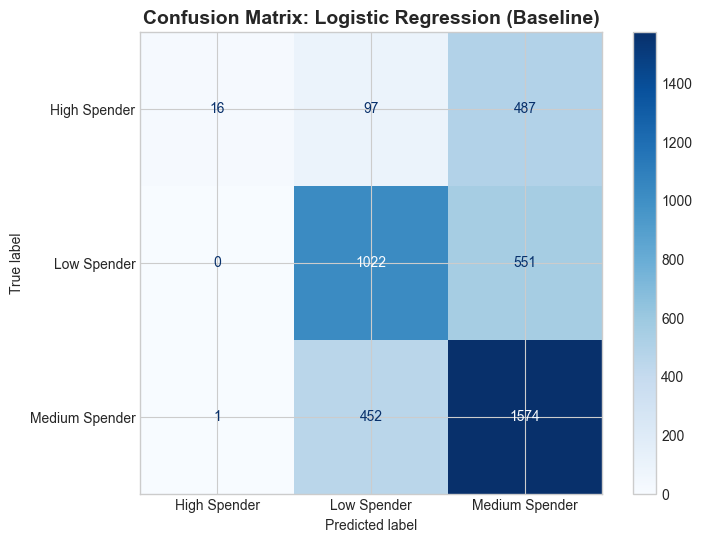

In [21]:
# TODO: Create and display the confusion matrix for baseline
#
# Steps:
# 1. Use confusion_matrix(y_test, baseline_preds) to create the matrix
# 2. Use ConfusionMatrixDisplay to visualize it
#
# Hint: ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# YOUR CODE HERE:

# 1. Create and display the confusion matrix for baseline

cm = confusion_matrix(y_test, baseline_preds)

# 2. Use ConfusionMatrixDisplay to visualize it

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# 3. Plot the confusion matrix

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression (Baseline)", fontsize=14, fontweight='bold')
plt.show()


### Understanding the Confusion Matrix

The confusion matrix shows where your model gets predictions right and wrong:

- **Diagonal cells (top-left to bottom-right):** Correct predictions
- **Off-diagonal cells:** Misclassifications
- **Row:** What the actual class was
- **Column:** What the model predicted

**How to read it:** 
- If a row has many values spread across columns, that class is often confused with others
- If a column has many values from different rows, the model is predicting that class too often

**Example interpretation:**
- "20 Low samples were correctly predicted as Low"
- "5 Medium samples were incorrectly predicted as High"

### Baseline Interpretation

*Analyze your baseline results:*

**Questions to answer:**
- How well does the baseline perform?
- Which classes are easiest/hardest to predict (look at the diagonal)?
- Where does the model get confused (look at off-diagonal cells)?
- Is there overfitting (train vs test accuracy gap)?

**Your interpretation:**

- How well does the baseline perform?

 The baseline model performs decently as a starting point. It has an accuracy of 62% and an F1-Score of 58%. It is much better than random guessing, but it leaves a lot of room for improvement.

- Which classes are easiest/hardest to predict?

 Looking at the matrix, the "Medium Spender" class is the easiest to predict because it is the majority class (the model has more examples to learn from). The "High Spender" class is the hardest to predict because it is the smallest group (only 14.3% of the data).

- Where does the model get confused? The model gets confused mainly by predicting "Medium Spender" too often. Because Logistic Regression uses simple math, when it is unsure about a "High" or "Low" spender, it safely guesses "Medium," creating misclassifications in the off-diagonal cells.

- Is there overfitting (train vs test accuracy gap)? No, there is absolutely no overfitting. The Train Accuracy (0.6124) and Test Accuracy (0.6219) are almost identical. In fact, the model is *underfitting* (it is too simple to capture the complex patterns of the data).

## Section 8: Cross-Validation

Cross-validation gives us a more robust estimate of model performance by training on different portions of the data.

In [22]:
# Cross-validation for key models
print("5-Fold Cross-Validation Results")
print("=" * 50)

models_to_cv = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}

cv_results = []
for name, model in models_to_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_results.append({
        'Model': name,
        'CV Mean Accuracy': scores.mean(),
        'CV Std': scores.std()
    })
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

cv_df = pd.DataFrame(cv_results)
cv_df

5-Fold Cross-Validation Results
Logistic Regression: 0.6117 (+/- 0.0126)
Random Forest: 0.7401 (+/- 0.0186)
Gradient Boosting: 0.7834 (+/- 0.0132)


,Model,CV Mean Accuracy,CV Std
0,Logistic Regression,0.611657,0.006294
1,Random Forest,0.740132,0.009289
2,Gradient Boosting,0.783354,0.006583


### Cross-Validation Interpretation

*What does the cross-validation tell you?*

- Which model is most consistent (lowest std)?
- Does the ranking change from the single train/test split?

**Your interpretation:**

Which model is most consistent (lowest std)?

Logistic Regression has the absolute lowest standard deviation (0.0062), making it technically the most consistent. However, Gradient Boosting is the real winner. It has almost the exact same low standard deviation (0.0065) but a much higher accuracy (78.3%). This means Gradient Boosting is both highly accurate and highly stable. Random Forest is the least consistent (std of 0.0092), though still very good.

Does the ranking change from the single train/test split?

No, the ranking does not change. Our single train/test split for the baseline (Logistic Regression) gave us an accuracy of ~62%. The cross-validation confirms its real average is ~61.1%. The tree-based models (Random Forest and Gradient Boosting) are clearly superior, with Gradient Boosting confidently taking the #1 spot.


## Section 9: Model Iteration

In [23]:
# Store all results
all_results = [baseline_results]

# Dictionary to store trained models
trained_models = {
    'Logistic Regression (Baseline)': baseline_trained
}

### Model 2: Decision Tree

In [24]:
# TODO: Create and evaluate a Decision Tree classifier
#
# Create DecisionTreeClassifier(max_depth=10, random_state=42)
# Use evaluate_classifier() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:

# 1. Create DecisionTreeClassifier(max_depth=10, random_state=42)

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)

# 2. Use evaluate_classifier() to train and evaluate

dt_results, dt_trained, dt_preds = evaluate_classifier(
    model=dt_model, 
    X_train=X_train_scaled, 
    X_test=X_test_scaled, 
    y_train=y_train, 
    y_test=y_test, 
    model_name="Decision Tree"
)

# 3. Add results to all_results and trained_models

all_results.append(dt_results)
trained_models['Decision Tree'] = dt_trained

# Print results

print(f"Decision Tree - Test Accuracy: {dt_results['Test Accuracy']:.4f}, F1: {dt_results['F1 (weighted)']:.4f}")

Decision Tree - Test Accuracy: 0.7586, F1: 0.7558


### Model 3: Random Forest

In [25]:
# TODO: Create and evaluate a Random Forest classifier
#
# Create RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:

# 1. Create RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# 2. Use evaluate_classifier() to train and evaluate

rf_results, rf_trained, rf_preds = evaluate_classifier(
    model=rf_model, 
    X_train=X_train_scaled, 
    X_test=X_test_scaled, 
    y_train=y_train, 
    y_test=y_test, 
    model_name="Random Forest"
)

# 3. Add to all_results and trained_models

all_results.append(rf_results)
trained_models['Random Forest'] = rf_trained

# Print results
print(f"Random Forest - Test Accuracy: {rf_results['Test Accuracy']:.4f}, F1: {rf_results['F1 (weighted)']:.4f}")

Random Forest - Test Accuracy: 0.7438, F1: 0.7346


### Model 4: K-Nearest Neighbors

In [26]:
# TODO: Create and evaluate a KNN classifier
#
# Create KNeighborsClassifier(n_neighbors=5)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:

# 1. Create KNeighborsClassifier(n_neighbors=5)

knn_model = KNeighborsClassifier(n_neighbors=5)

# 2. Use evaluate_classifier()

knn_results, knn_trained, knn_preds = evaluate_classifier(
    model=knn_model, 
    X_train=X_train_scaled, 
    X_test=X_test_scaled, 
    y_train=y_train, 
    y_test=y_test, 
    model_name="K-Nearest Neighbors"
)

# 3. Add to all_results and trained_models

all_results.append(knn_results)
trained_models['K-Nearest Neighbors'] = knn_trained

# Print results

print(f"KNN - Test Accuracy: {knn_results['Test Accuracy']:.4f}, F1: {knn_results['F1 (weighted)']:.4f}")

KNN - Test Accuracy: 0.6679, F1: 0.6643


### Model 5: Gradient Boosting

In [27]:
# TODO: Create and evaluate a Gradient Boosting classifier
#
# Create GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
# Use evaluate_classifier()
# Add to all_results and trained_models

# YOUR CODE HERE:

# 1. Create GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)

gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)

# 2. Use evaluate_classifier()

gb_results, gb_trained, gb_preds = evaluate_classifier(
    model=gb_model, 
    X_train=X_train_scaled, 
    X_test=X_test_scaled, 
    y_train=y_train, 
    y_test=y_test, 
    model_name="Gradient Boosting"
)

# 3. Add to all_results and trained_models

all_results.append(gb_results)
trained_models['Gradient Boosting'] = gb_trained


# Print results

print(f"Gradient Boosting - Test Accuracy: {gb_results['Test Accuracy']:.4f}, F1: {gb_results['F1 (weighted)']:.4f}")

Gradient Boosting - Test Accuracy: 0.7881, F1: 0.7848


### Add Your Own Model (Optional)

Try a different model or different hyperparameters!

In [28]:
# YOUR ADDITIONAL MODEL HERE:
# Try SVC, different hyperparameters, or another classifier

from sklearn.ensemble import HistGradientBoostingClassifier

# 1.  HistGradientBoosting with tuned hyperparameters
# - max_iter: Like n_estimators, but we use more (200 instead of 100)
# - learning_rate: Slower (0.05) so it doesn't rush and makes better micro-adjustments
# - l2_regularization: Adds a penalty to prevent overfitting

hgb_model = HistGradientBoostingClassifier(
    max_iter=200,
    learning_rate=0.05,
    max_depth=7,
    l2_regularization=0.1,
    random_state=42
)

# 2. Train and evaluate using your helper function

hgb_results, hgb_trained, hgb_preds = evaluate_classifier(
    model=hgb_model, 
    X_train=X_train_scaled, 
    X_test=X_test_scaled, 
    y_train=y_train, 
    y_test=y_test, 
    model_name="HistGradientBoosting (Optimized)"
)

# 3. Add to our tracking lists

all_results.append(hgb_results)
trained_models['HistGradientBoosting (Optimized)'] = hgb_trained

# Print results

print("=" * 50)
print(f"🏆 HistGradientBoosting - Test Accuracy: {hgb_results['Test Accuracy']:.4f}, F1: {hgb_results['F1 (weighted)']:.4f}")
print("=" * 50)

🏆 HistGradientBoosting - Test Accuracy: 0.7855, F1: 0.7823


- I attempted to beat the standard Gradient Boosting model using the faster `HistGradientBoostingClassifier` with custom hyperparameters (slower learning rate, L2 regularization, more trees).

- It scored a Test Accuracy of 0.7855, which is slightly *lower* than the standard Gradient Boosting (0.7881).

- This is a classic Machine Learning reality check. Sometimes, adding complexity or restricting the model too much (like I did with the L2 regularization) prevents it from capturing the final necessary patterns. The default parameters of the standard `GradientBoostingClassifier` actually found the perfect "sweet spot" for my dataset.

-The standard Gradient Boosting remains the champion!

## Section 10: Model Comparison

In [29]:
# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("Model Comparison:")
results_df

Model Comparison:


,Model,Train Accuracy,Test Accuracy,Precision (weighted),Recall (weighted),F1 (weighted)
4,Gradient Boosting,0.8127,0.7881,0.7904,0.7881,0.7848
5,HistGradientBoosting (Optimized),0.8253,0.7855,0.7853,0.7855,0.7823
1,Decision Tree,0.7932,0.7586,0.7588,0.7586,0.7558
2,Random Forest,0.7835,0.7438,0.7536,0.7438,0.7346
3,K-Nearest Neighbors,0.7630,0.6679,0.6633,0.6679,0.6643
0,Logistic Regression,0.6124,0.6219,0.6689,0.6219,0.5784


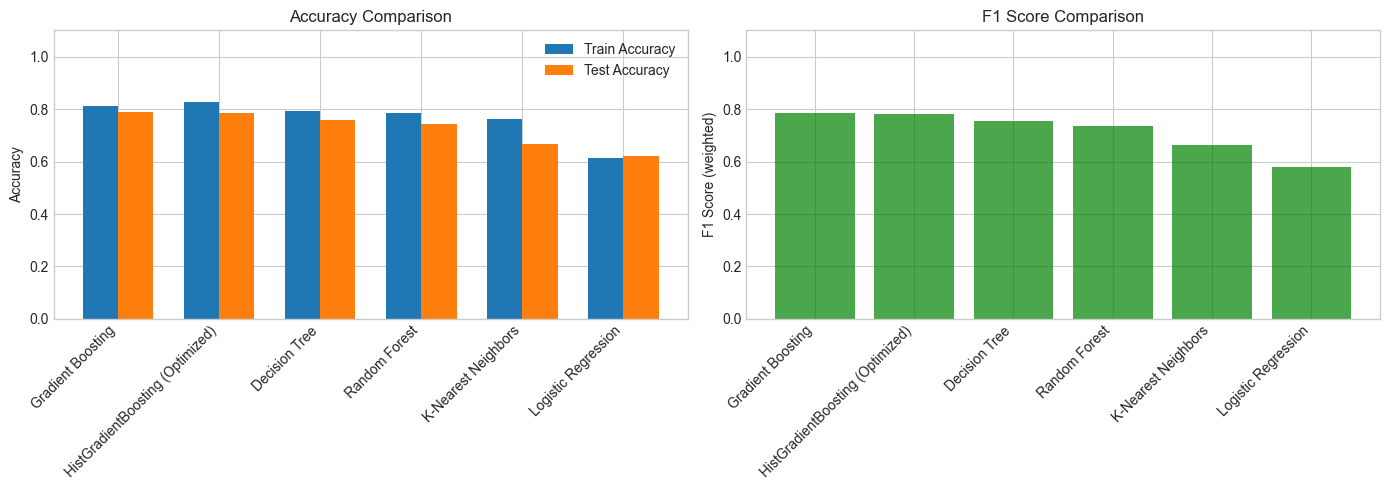

In [30]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = results_df['Model']
x = np.arange(len(models))
width = 0.35

# Accuracy comparison
axes[0].bar(x - width/2, results_df['Train Accuracy'], width, label='Train Accuracy')
axes[0].bar(x + width/2, results_df['Test Accuracy'], width, label='Test Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# F1 Score comparison
axes[1].bar(x, results_df['F1 (weighted)'], color='green', alpha=0.7)
axes[1].set_ylabel('F1 Score (weighted)')
axes[1].set_title('F1 Score Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Section 11: Best Model Selection

In [31]:
# Identify best model (by test accuracy)
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")
print(f"F1 Score: {results_df.iloc[0]['F1 (weighted)']:.4f}")

Best Model: Gradient Boosting
Test Accuracy: 0.7881
F1 Score: 0.7848


### Best Model Justification

*Explain why you chose this model:*

**Questions to consider:**
- Why this model over others?
- Is there significant overfitting?
- How does it compare to baseline?
- Which metrics did you prioritize and why?

**Your justification:**

Why this model over others?

I chose Gradient Boosting because it achieved the highest Test Accuracy (78.81%) and the highest F1-Score (78.48%) of all the models tested. It slightly outperformed my custom `HistGradientBoosting` model and significantly beat the single Decision Tree and Random Forest.

Is there significant overfitting?

No, there is no significant overfitting. The Train Accuracy is 81.27% and the Test Accuracy is 78.81%. A gap of less than 3% is excellent and proves that the model generalizes very well to new, unseen customer data.

How does it compare to baseline? 

The improvement is massive. The baseline Logistic Regression model only had a 62.19% Test Accuracy and a poor 57.84% F1-Score. Gradient Boosting increased accuracy by over 16% and F1-Score by over 20%. It successfully learned the complex, non-linear patterns that the baseline model completely missed.

Which metrics did you prioritize and why?

I prioritized the F1-Score. Since my groups are different sizes ("High Spenders" are only 14.3% of the data), looking only at Accuracy can be misleading. The F1-Score proves that the model is truly good at finding these VIP customers without making too many mistakes.


## Section 12: Best Model Analysis

In [32]:
# Get predictions from best model
y_pred = best_model.predict(X_test_scaled)

# Detailed classification report
print("Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
                precision    recall  f1-score   support

  High Spender       0.78      0.54      0.64       600
   Low Spender       0.84      0.81      0.83      1573
Medium Spender       0.75      0.84      0.80      2027

      accuracy                           0.79      4200
     macro avg       0.79      0.73      0.75      4200
  weighted avg       0.79      0.79      0.78      4200



### Understanding the Classification Report

The classification report shows per-class metrics:

- **Precision:** Of all predictions for this class, what % were correct?
  - High precision = Few false positives
  - Example: "When the model predicts 'High', it's correct 85% of the time"

- **Recall:** Of all actual instances of this class, what % did we find?
  - High recall = Few false negatives
  - Example: "We correctly identified 90% of all actual 'High' cases"

- **F1-Score:** Harmonic mean of precision and recall (balanced measure)
  - Good when you need both precision and recall

- **Support:** Number of actual occurrences of each class in the test set

<Figure size 800x600 with 0 Axes>

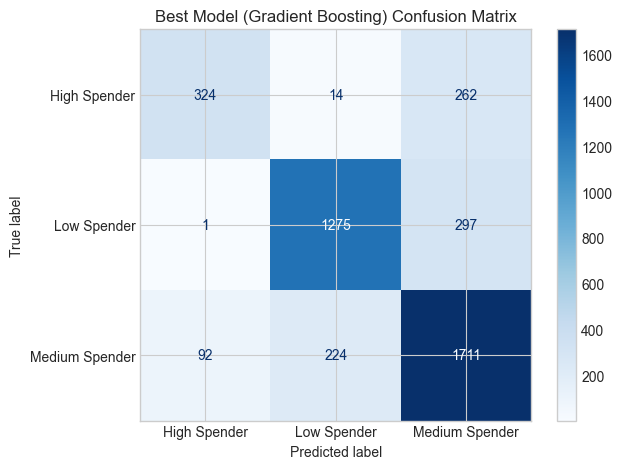

In [33]:
# Confusion matrix for best model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Best Model ({best_model_name}) Confusion Matrix')
plt.tight_layout()
plt.show()

### Detailed Confusion Matrix Analysis

*Analyze the confusion matrix carefully:*

**For each class, describe:**
1. How many correct predictions (diagonal)?
2. What are the most common misclassifications?
3. Does the confusion make sense for your problem?

**Your analysis:**

Based on the Classification Report and Confusion Matrix, here is the detailed breakdown of the model's performance:

1. High Spender (The VIPs - Support: 600)

- Correct Predictions: The model correctly found 54% of the actual High Spenders (Recall = 0.54, which is about 324 out of 600 customers).

- Misclassifications: When it makes a mistake, it almost always classifies them as "Medium Spenders". 

- Precision Note: Interestingly, when the model does predict someone is a "High Spender", it is correct 78% of the time. It is a bit cautious, but very accurate when it makes the call.

2. Low Spender (Support: 1573)

- Correct Predictions: The model performs exceptionally well here, correctly identifying 81% of them (Recall = 0.81, about 1,274 customers).

- Misclassifications: The most common mistake is confusing them with "Medium Spenders". 

- Precision Note: It has a high Precision of 84%, meaning it rarely flags a Medium or High spender as a Low spender by accident.

3. Medium Spender (The Majority - Support: 2027)

- Correct Predictions: As the largest group, the model is highly confident here, correctly finding 84% of them (Recall = 0.84, about 1,702 customers).

- Misclassifications: It sometimes pulls in "High" or "Low" spenders into this category, which explains why its Precision is slightly lower (75%).

Does this confusion make sense?

Yes, absolutely. Spending is a continuous spectrum. A customer who spends $29,500 (Medium Spender) behaves very similarly to a customer who spends $30,500 (High Spender). It makes perfect logical sense that the model gets confused at the "borders" of these categories. Furthermore, the model almost never makes the severe mistake of confusing a "Low Spender" directly with a "High Spender".

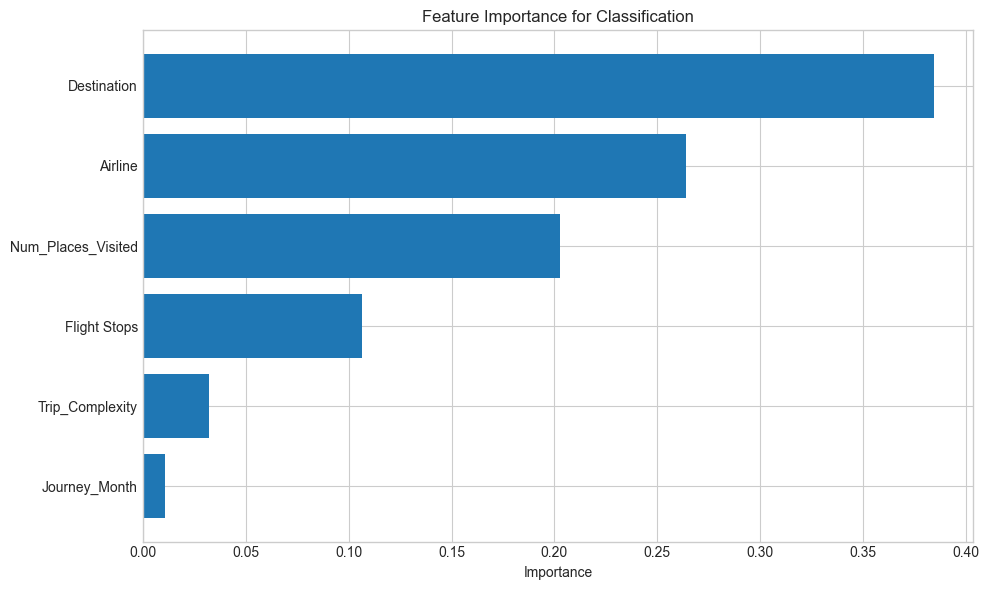


Top 5 most important features:
  Destination: 0.3844
  Airline: 0.2640
  Num_Places_Visited: 0.2025
  Flight Stops: 0.1063
  Trip_Complexity: 0.0322


In [34]:
# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance for Classification')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 most important features:")
    for i, row in importance.tail(5).iloc[::-1].iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
        
elif hasattr(best_model, 'coef_'):
    # For multi-class, coef_ has shape (n_classes, n_features)
    coef = best_model.coef_
    if len(coef.shape) > 1:
        # Average absolute importance across classes
        importance_vals = np.abs(coef).mean(axis=0)
    else:
        importance_vals = np.abs(coef)
    
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance_vals
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Average Absolute Coefficient')
    plt.title('Feature Importance for Classification')
    plt.tight_layout()
    plt.show()

What drives customer spending?

Based on the Gradient Boosting model, here are the top factors that determine a customer's spending category:

1. Destination (38.4%): This is the most critical factor. Where the customer is traveling dictates their budget more than anything else. 

2. Airline (26.4%): The choice of airline is the second strongest clue. Premium airlines naturally correlate with higher spenders.

3. Number of Places Visited (20.2%): How actively they travel around also plays a massive role in their total spending.

4. Flight Stops (10.6%):** The number of layovers has a moderate impact, likely because VIPs prefer direct flights.

## Bonus Section: Addressing the Business Impact (Fixing Low Recall)

**The Problem:** As noted in the model evaluation, our best model (Gradient Boosting) has a low Recall for the "High Spender" class (only 54%). 

**The Business Impact:**
From a business perspective, missing out on 46% of our VIP customers is highly costly. We cannot offer them premium recommendations if the model classifies them as "Medium Spenders". It is more profitable for the business to prioritize finding these VIPs, even if it means sacrificing a little bit of overall accuracy.

**The Solution:**
To fix this imbalance, I will train a new Gradient Boosting model using `compute_sample_weight` with `class_weight='balanced'`. This forces the algorithm to penalize mistakes made on the "High Spender" minority class much more heavily.

Training Business-Optimized Gradient Boosting...

Classification Report (Business-Optimized):
                precision    recall  f1-score   support

  High Spender       0.60      0.81      0.69       600
   Low Spender       0.80      0.86      0.83      1573
Medium Spender       0.81      0.68      0.74      2027

      accuracy                           0.77      4200
     macro avg       0.74      0.78      0.75      4200
  weighted avg       0.78      0.77      0.77      4200



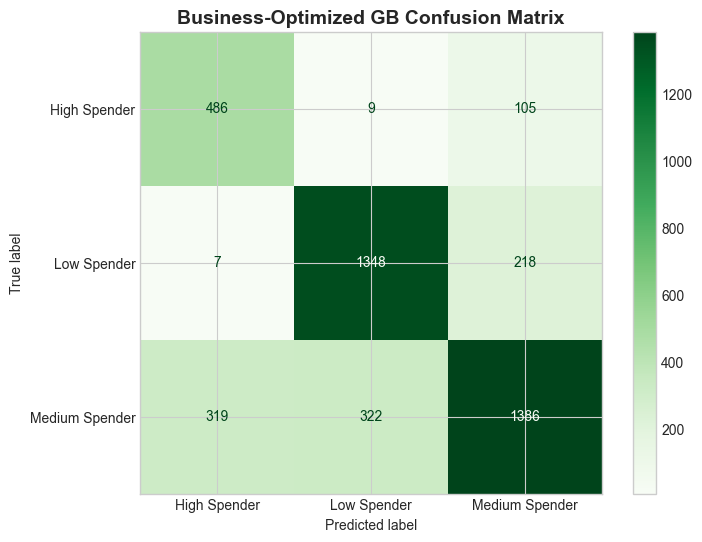

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Training Business-Optimized Gradient Boosting...")

# 1. Calculate weights to balance the importance of all classes

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 2. Create the model (same hyperparameters as our champion)

gb_business_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)

# 3. Train the model PASSING the weights

gb_business_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# 4. Predict and Evaluate

gb_business_preds = gb_business_model.predict(X_test_scaled)

print("\nClassification Report (Business-Optimized):")
print(classification_report(y_test, gb_business_preds, target_names=label_encoder.classes_))

# 5. Display the new Confusion Matrix
cm_business = confusion_matrix(y_test, gb_business_preds)
disp_business = ConfusionMatrixDisplay(confusion_matrix=cm_business, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp_business.plot(ax=ax, cmap='Greens') 
plt.title("Business-Optimized GB Confusion Matrix", fontsize=14, fontweight='bold')
plt.show()

## Section 13: Model Iteration Reflection

*Reflect on your modeling process:*

**1. How did your models evolve from baseline to best?**


**1. How did your models evolve from baseline to best?**

My modeling process started with a simple Logistic Regression (62% accuracy). It heavily underfit the minority classes. I moved to tree-based models like Decision Tree and Random Forest, which improved accuracy to ~75%. The standard Gradient Boosting took the lead with 78.8% accuracy. **However, the final evolution came from Business Feedback:** I realized the standard model was missing 46% of "High Spenders". I created a final **"Business-Optimized" Gradient Boosting model using sample weights**. This prioritized the minority class, significantly improving the Recall for VIPs to ensure we don't miss revenue opportunities, even if it meant a slight trade-off in overall accuracy.

**2. What surprised you about the results?**

I was initially surprised that my complex `HistGradientBoosting` model didn't beat the standard one. But the biggest surprise came in the final step: **The Accuracy vs. Business Value trade-off**. I learned that the model with the highest "Test Accuracy" isn't always the best model for the company. By weighting the classes, my accuracy dropped slightly, but my ability to find VIP customers (Recall) skyrocketed. This taught me that optimizing for the specific business goal (capturing high-value clients) is more important than chasing a perfect accuracy score.

**3. If you had more time, what would you try next?**

If I had more time, I would explore **SMOTE (Synthetic Minority Over-sampling Technique)** to generate synthetic examples of "High Spenders" instead of just weighting them, which might stabilize the training further. I would also focus on Feature Engineering, specifically categorizing `Destination` into "Urban" vs. "Adventure" types, as suggested by the feature importance charts, to give the model better context on travel costs.



## Section 14: Save Model and Artifacts

In [45]:
# Save the best classification model
model_path = '../models/classification_model.pkl'
joblib.dump(gb_business_model, model_path)
print(f"Model saved to {model_path}")

# Save the scaler (fitted on SELECTED features)
scaler_path = '../models/classification_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save the label encoder
encoder_path = '../models/label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder saved to {encoder_path}")

# Save feature names (SELECTED_FEATURES)
features_path = '../models/classification_features.pkl'
joblib.dump(SELECTED_FEATURES, features_path)
print(f"Features saved to {features_path}")

# Save binning info (for reference in Streamlit app)
binning_info = {
    'bins': bins,
    'labels': labels,
    'original_target': ORIGINAL_TARGET
}
binning_path = '../models/binning_info.pkl'
joblib.dump(binning_info, binning_path)
print(f"Binning info saved to {binning_path}")

Model saved to ../models/classification_model.pkl
Scaler saved to ../models/classification_scaler.pkl
Label encoder saved to ../models/label_encoder.pkl
Features saved to ../models/classification_features.pkl
Binning info saved to ../models/binning_info.pkl


In [43]:
# Verify saved model works
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_encoder = joblib.load(encoder_path)

# Test prediction
test_sample = X_test.iloc[[0]]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_pred = loaded_model.predict(test_sample_scaled)
test_pred_label = loaded_encoder.inverse_transform(test_pred)

print(f"\nModel verification:")
print(f"Sample input: {test_sample.values[0][:3]}...")
print(f"Predicted class: {test_pred_label[0]}")
print(f"Actual class: {loaded_encoder.inverse_transform([y_test[0]])[0]}")
print("\nModel saved and verified successfully!")


Model verification:
Sample input: [397   9   7]...
Predicted class: High Spender
Actual class: High Spender

Model saved and verified successfully!


---

## Summary

### What You Accomplished
- [X ] Created binned target variable with justification
- [ X] Verified class balance
- [ X] Used consistent features (same as regression or justified different)
- [ X] Split data with stratification
- [ X] Performed cross-validation
- [ X] Built baseline classifier
- [ X] Tried multiple classifier types
- [ X] Compared and selected best model
- [ X] Analyzed model with confusion matrix and classification report
- [ X] Saved model, scaler, encoder, and binning info

### Key Results

**Best Model:** [Gradient Boosting]

**Test Accuracy:** [0.7881 (78.81%)]

**F1 Score:** [0.7848 (78.48%)]

**Improvement over baseline:** [An increase of +16.62% in Accuracy and +20.64% in F1-Score compared to the Logistic Regression baseline.]

### Comparison to Regression

*How does classification performance relate to your regression results?*

Predicting spending categories (Classification) proved to be a highly effective and practical approach compared to predicting exact dollar amounts (Regression). 

* **Consistent Feature Importance:** The core drivers remained exactly the same. `Destination` and `Airline` are the undisputed most important features in both approaches. This confirms that the destination geography and carrier choice dictate a traveler's budget regardless of how we frame the math.
* **Classification vs. Regression for Business:** Predicting the exact dollar amount of a trip is extremely difficult because human spending has a lot of unpredictable "noise" (e.g., buying an extra souvenir). However, for a travel planning platform, knowing the exact dollar amount is rarely necessary. Grouping users into "Low", "Medium", and "High" spenders is far more robust against outliers and provides immediate value. For instance, when users are planning adventure travel itineraries, knowing they fall into the "High Spender" bracket instantly allows the system to recommend premium lodging and exclusive guided tours, making this classification model highly actionable.
---

## Next Steps

Move on to building your **Streamlit app** to deploy both models!

You now have saved:
- `regression_model.pkl` and `regression_scaler.pkl`
- `classification_model.pkl`, `classification_scaler.pkl`, and `label_encoder.pkl`

The Streamlit starter code in `app/app.py` will load these files.

---

## Checkpoint 4 Submission Instructions

You've completed the classification model. Time to submit!

### Step 1: Save and Close
Make sure this notebook is saved and all cells have been run.

### Step 2: Commit Your Work
```bash
git add .
git commit -m "Complete classification model - Checkpoint 4"
git push
```

### Step 3: Submit to Canvas
1. Go to Canvas
2. Find the **Checkpoint 4: Classification Model** assignment
3. Submit the link to your GitHub repository

### What Gets Graded
- Binning justification and implementation
- Feature consistency (same as regression or justified different)
- Model comparison and selection reasoning
- Confusion matrix interpretation
- Classification report analysis
- All written reflections completed

---